In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats as st
import warnings 
warnings.filterwarnings('ignore') 

In [2]:
#Dados históricos no qual as projeções vão se basear

faixas = pd.read_csv('distribuicoes.csv')
faixas = faixas.set_index(faixas['Unnamed: 0'])
del faixas['Unnamed: 0']
faixas.index.name = 'faixa'
faixas

,media,dp
faixa,,
0.1,0.328,0.181
0.2,0.409,0.194
0.3,0.420,0.194
0.4,0.432,0.195
0.5,0.473,0.212
0.6,0.496,0.208
0.7,0.542,0.215
0.8,0.614,0.208


In [10]:
jogos = pd.read_csv('br22j - Página1.csv')

#del jogos['Unnamed: 0']

jogos.head()

,partida_id,homeTeam,awayTeam,data,homeScore,awayScore
0,1,373,262,2022-04-09 19:00:00,1,1
1,1,263,264,2022-04-10 16:00:00,1,3
2,1,314,327,2022-04-10 19:00:00,1,0
3,1,290,275,2022-04-16 16:30:00,1,1
4,1,354,263,2022-04-17 19:00:00,1,3


In [ ]:
#clubes br 22 - Página1.csv

In [11]:
df_clubes = pd.read_csv('clubes br 22 - Página1.csv')
df_clubes.head()

,clubeId,clubeNome,clubeNomeCodigo,clubeShortName,clubeSlug
0,262.0,Flamengo,FLA,Flamengo,flamengo
1,263.0,Botafogo,BOT,Botafogo,botafogo
2,264.0,Corinthians,COR,Corinthians,corinthians
3,266.0,Fluminense,FLU,Fluminense,fluminense
4,275.0,Palmeiras,PAL,Palmeiras,palmeiras


In [67]:
df_clubes["clubeId"] = df_clubes["clubeId"].map(int)
df_clubes.head()

,clubeId,clubeNome,clubeNomeCodigo,clubeShortName,clubeSlug
0,262,Flamengo,FLA,Flamengo,flamengo
1,263,Botafogo,BOT,Botafogo,botafogo
2,264,Corinthians,COR,Corinthians,corinthians
3,266,Fluminense,FLU,Fluminense,fluminense
4,275,Palmeiras,PAL,Palmeiras,palmeiras


In [69]:
clubes = dict()

for i in jogos.homeTeam.unique():
    clubes[str(int(i))] = jogos.loc[(jogos.homeTeam == i)|(jogos.awayTeam == i)].sort_values('data')
    
#Dicionário que vai guardar, já ordenado por data, o registro dos jogos de cada clube



In [70]:
for clube_id in clubes.keys():
    temp = clubes[clube_id] # Temp é um DataFrame temporário para a manipulação dos dados
    
    temp.awayTeam = temp.awayTeam.apply(lambda x: str(int(x)))
    temp.homeTeam = temp.homeTeam.apply(lambda x: str(int(x)))

    temp.loc[(temp.homeTeam == clube_id) & (temp.homeScore > temp.awayScore), 'aproveitamento'] = 1
    temp.loc[(temp.homeTeam == clube_id) & (temp.homeScore == temp.awayScore), 'aproveitamento'] = 0.333
    temp.loc[(temp.homeTeam == clube_id) & (temp.homeScore < temp.awayScore), 'aproveitamento'] = 0

    temp.loc[(temp.awayTeam == clube_id) & (temp.homeScore > temp.awayScore), 'aproveitamento'] = 0
    temp.loc[(temp.awayTeam == clube_id) & (temp.homeScore < temp.awayScore), 'aproveitamento'] = 1
    temp.loc[(temp.awayTeam == clube_id) & (temp.homeScore == temp.awayScore), 'aproveitamento'] = 0.333

    temp['mm_5'] = temp.aproveitamento.rolling(5).mean()
    temp['mm_10'] = temp.aproveitamento.rolling(10).mean()
    temp['num_jogos'] = range(1, len(temp)+1)
    
    
clubes[clube_id] = temp # Tratado, devolve-se o DataFrame para o lugar de origem

In [71]:
#Funcao onde toda magia acontece. Ela é quem vai fazer toda as simulações. A princípio houve uma certa cautela com o fato dela usar listas e fazer as simulações uma a uma, mas ainda sim entrega por volta de 1000 simulações por segundo. No decorrer do código é discutido simulações usando o Numpy e o Pandas.Funcao onde toda magia acontece. Ela é quem vai fazer toda as simulações. A princípio houve uma certa cautela com o fato dela usar listas e fazer as simulações uma a uma, mas ainda sim entrega por volta de 1000 simulações por segundo. No decorrer do código é discutido simulações usando o Numpy e o Pandas.

In [72]:
def monte_carlo(df): # Recebe o DataFrame anteriormente tratado
    
    global faixas
    
    num_jogos = df[-1:].num_jogos.values[0] # Quantos jogos jogou o clube?
    
    mm_5 = round(df[-1:].mm_5.values[0],1)   # Média movel dos últimos 5
    mm_10 = round(df[-1:].mm_10.values[0],1) # Média movel dos últimos 10
    mm_pre_5 = 2*mm_10 - mm_5                # Media movel dos 5 jogos que antecederam os últimos 5
    
    pontos = [round(df.aproveitamento.mean() * (3 * num_jogos))] # Começa uma lista que vai guardar essa "realidade" simulada
    # Índice é os eixos x dos gráficos, acredito que só um pra cada clube, mas fica essa solução como registro 
    indice = [num_jogos]                                        
    
    while num_jogos < 38: # Enquanto não exceder o número de rodadas do campeonato, continua simulando
        mm_10 = round((mm_pre_5 + mm_5)/2, 1)
        
        # Como discutido no código anterior, algumas faixas foram unidas, essa sequencia de IF cuida disso
        if mm_10 >0.8: 
            mm_10 = 0.8
        elif mm_10<0.1:
            mm_10 = 0.1     
        else:
            pass
        
        mm_pre_5 = mm_5 # Guarda a última media movel dos 5 jogos anteriores
        mm_5 = random.gauss(faixas.loc[mm_10, 'media'], faixas.loc[mm_10, 'dp']) # Simula uma nova média móvel
        
        # O aproveitamento não pode ser nem maior que 1 e nem menor que 0, a sequencia de IF cuida disso
        if mm_5 >1:
            mm_5 = 1
        elif mm_5<0:
            mm_5 = 0
        else:
            pass
        
        # Dá um 'passo' pro futuro
        num_jogos += 5
    
        # Excedeu-se o número de partidas do campenato? Faz uma interpolação com as médias anteriores
        if num_jogos > 38:
            
            dy = (pontos[-1] - pontos[-2])/5  # media de ponto nos últimos 5 jogos
            n_jogos = 38 - indice[-1] 
            
            pontos.append(round(pontos[-1] + n_jogos*dy,0))
            indice.append(38)
            
        else: 
            
            pontos.append(round(pontos[-1] + mm_5 * 15, 0))
            indice.append(num_jogos)
        
    return indice, pontos

In [73]:
pontuacao_real = dict()
pontuacao_simulada = dict()

for clube_id in clubes.keys():
    num_jogos = clubes[clube_id].num_jogos.values   # vetor o numero de jogos
    pontos = [round(clubes[clube_id].loc[:i, 'aproveitamento'].mean() * 3 * clubes[clube_id].loc[i, 'num_jogos'],0) for i in clubes[clube_id].index]
    
    pontuacao_real[clube_id] = np.array([num_jogos, pontos])
    
    simulacoes = []
    for i in range(1000):
        simulacoes.append([monte_carlo(clubes[clube_id])])
        
    pontuacao_simulada[clube_id] = np.array(simulacoes)

In [74]:
#Script que guarda um vetor com todas as pontuacoes finais nas simulacoes
pontuacao_final = dict()

for clube_id in clubes.keys():
    
    pont_final = []
    for i in pontuacao_simulada[clube_id]:
        pont_final.append(i[0][1][-1])
        
    pontuacao_final[clube_id] = pont_final

In [75]:
clube_id = '277'
cor_princ = '#000000'
cor_sec = '#696969'
nome = 'Santos'

posicoes_santos = pd.Series()


for j in range(1000):
    pont_santos = pontuacao_final[clube_id][j]  # pontuacao final do Santos na simulação j
    menores = 0
    
    for i in clubes.keys():
        if pontuacao_final[i][j] < pont_santos:  # O clube pontuou menos que o Santos?
            menores += 1
        else:
            pass
    
    p = str(20 - menores) # Posicao do Santos na Simulacao
    
    if p in posicoes_santos.index: # Faz a contagem de posições
        posicoes_santos[p] += 1
    else:
        posicoes_santos[p] = 1
        
posicoes_santos.index = posicoes_santos.index.astype('int')
posicoes_santos = posicoes_santos.sort_index()

posicoes_santos = posicoes_santos/posicoes_santos.sum()

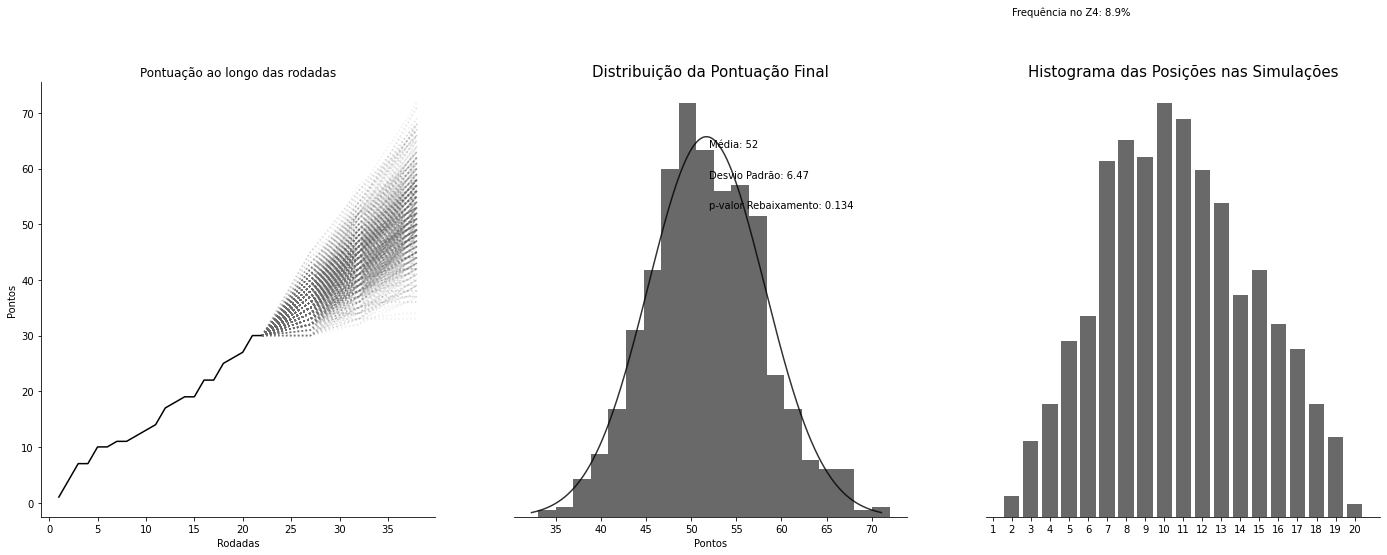

In [76]:
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# EVOLUCAO DA PONTUACAO NO TEMPO

# Pontos reais 
axs[0].plot(pontuacao_real[clube_id][0], pontuacao_real[clube_id][1], '-', color=cor_princ, label=nome)

# Pontos Projetados
for j in pontuacao_simulada[clube_id]:
        axs[0].plot(j[0][0], j[0][1], ':', color=cor_sec, alpha=0.1)
        
axs[0].set_title('Pontuação ao longo das rodadas')
axs[0].set_xlabel('Rodadas')
axs[0].set_ylabel('Pontos')
axs[0].spines['right'].set_visible(False) 
axs[0].spines['top'].set_visible(False)


# HISTOGRAMA DA PONTUACAO FINAL

axs[1].hist(pontuacao_final[clube_id], color=cor_sec,density=True, bins=20)
mu = np.array(pontuacao_final[clube_id]).mean()
sigma = np.array(pontuacao_final[clube_id]).std()

z_value = (44.5-mu)/sigma
p_value = st.norm.cdf(z_value)

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
axs[1].plot(x, st.norm.pdf(x, mu, sigma), '-', color=cor_princ, alpha=0.8)

axs[1].text(52, 0.06, f'Média: {int(round(mu,0))}')
axs[1].text(52, 0.055, f'Desvio Padrão: {round(sigma,2)}')
axs[1].text(52, 0.05, f'p-valor Rebaixamento: {round(p_value,3)}')

axs[1].set_title('Distribuição da Pontuação Final', fontsize=15)
axs[1].get_yaxis().set_visible(False)
axs[1].spines['right'].set_visible(False)          
axs[1].spines['top'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].set_xlabel('Pontos')

# HISTOGRAMA DAS POSICOES

rebaixado = posicoes_santos.loc[posicoes_santos.index > 16].sum()


axs[2].bar(posicoes_santos.index, posicoes_santos, color = cor_sec)

axs[2].set_xticks(range(1,21)) 
axs[2].get_yaxis().set_visible(False)
axs[2].spines['right'].set_visible(False)          
axs[2].spines['top'].set_visible(False)
axs[2].spines['left'].set_visible(False)
axs[2].text(2, 0.12, f'Frequência no Z4: {100*rebaixado}%')
axs[2].set_title('Histograma das Posições nas Simulações', fontsize=15)

plt.savefig('Santos o time do.png', dpi=400)

plt.show()

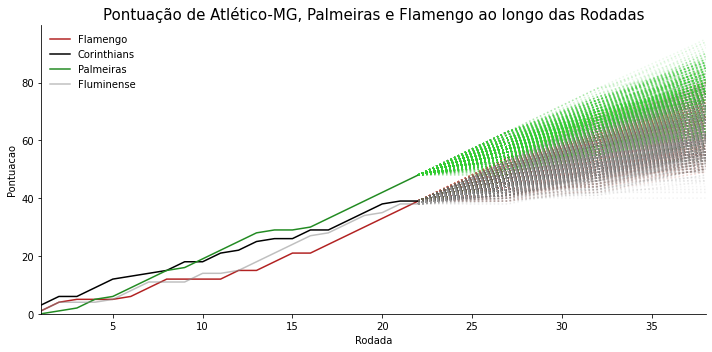

In [93]:
clube_id = ['262', '264', '275', '266']
cor_princ = ['#B22222','#000000','#228B22', '#8888']
cor_sec = ['#FF6347','#696969', '#32CD32', '#9999']
nome = ['Flamengo', 'Corinthians', 'Palmeiras', 'Fluminense']

fig, axs = plt.subplots(1, 1, figsize=(10, 5))

# Pontos reais
for i in range((len(clube_id))):
    axs.plot(pontuacao_real[clube_id[i]][0], pontuacao_real[clube_id[i]][1], '-', color=cor_princ[i], label=nome[i])

# Pontos Projetados
for i in range((len(clube_id))):
    for j in pontuacao_simulada[clube_id[i]]:
        axs.plot(j[0][0], j[0][1], ':', color=cor_sec[i], alpha=0.1)
    
    
# Configurando gráfico 

axs.set_title(f'Pontuação de Atlético-MG, Palmeiras e Flamengo ao longo das Rodadas', fontsize=15)
axs.set_xlabel('Rodada')
axs.set_ylabel('Pontuacao')
axs.set_xlim(xmin=1, xmax=38)
axs.set_ylim(ymin=0)

axs.spines['right'].set_visible(False)       
axs.spines['top'].set_visible(False)

axs.legend(frameon=False)
plt.tight_layout()

plt.savefig('Corrida ao título.png', dpi=500)
plt.show()

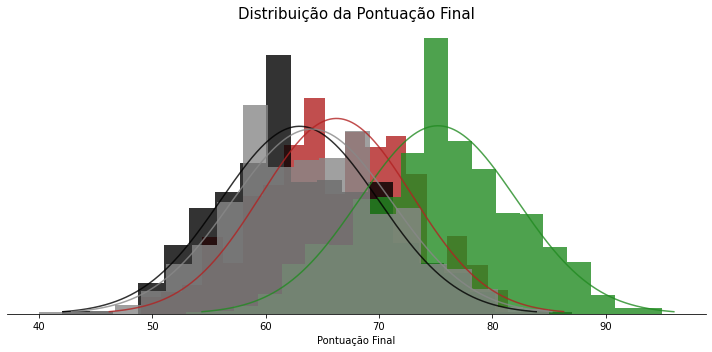

In [94]:
clube_id = ['262', '264', '275', '266']
cor_princ = ['#B22222','#000000','#228B22', '#8888']

fig, axs = plt.subplots(1, 1, figsize=(10,5))


for i in range((len(clube_id))):
    axs.hist(pontuacao_final[clube_id[i]], color=cor_princ[i],density=True, alpha=0.8, bins=20)
    
    mu = np.array(pontuacao_final[clube_id[i]]).mean()
    sigma = np.array(pontuacao_final[clube_id[i]]).std()
    
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
    axs.plot(x, st.norm.pdf(x, mu, sigma), '-', color=cor_princ[i], alpha=0.8, label=nome[i])
    
    
axs.set_title('Distribuição da Pontuação Final', fontsize=15)
axs.get_yaxis().set_visible(False)
axs.spines['right'].set_visible(False)          
axs.spines['top'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_xlabel('Pontuação Final')


plt.tight_layout()

plt.savefig('histo titulo.png', dpi=500)
plt.show()

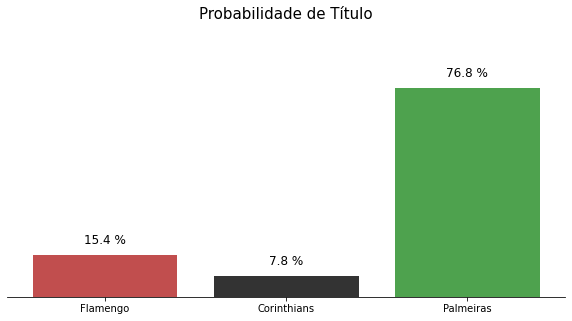

In [98]:
n = 1000000 # Numero de simulacoes

clube_id = ['262', '264', '275', '282']
cor_princ = [ '#B22222', '#000000', '#228B22']
nome = ['Flamengo', 'Corinthians', 'Palmeiras']

simul = []

fig, axs = plt.subplots(1, 1, figsize=(10,5))

for i in range((len(clube_id))):
    
    pts_fin = np.array(pontuacao_final[clube_id[i]])
    mu = pts_fin.mean()
    sigma = pts_fin.std()
    
    x = np.random.normal(mu, sigma, n) # Vetor aleatorio dos resultados possiveis
    simul.append(x)
    
    
# calcula o tamanho do vetor onde os clubes tiveram pontuacao melhor
fla_camp = 100* len(simul[0][(simul[0]>simul[1]) & (simul[0]>simul[2])])/n 
cor_camp = 100 * len(simul[1][(simul[1]>simul[0]) & (simul[1]>simul[2])])/n
pal_camp = 100 * len(simul[2][(simul[2]>simul[0]) & (simul[2]>simul[1])])/n


# Salva os resultados obtidos e formata-os para o gráfico
probabilidades = [fla_camp, cor_camp, pal_camp]
legenda = [f'{round(i,1)} %' for i in probabilidades]

# Plota os dados no grafico
plt.bar(nome, [fla_camp, cor_camp, pal_camp], color = cor_princ, alpha=0.8)

# Configura o gráfico
axs.get_yaxis().set_visible(False)
axs.spines['right'].set_visible(False)          
axs.spines['top'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_ylim(ymax=100)

eixo = axs.patches
for eixo, legenda in zip(eixo, legenda):
    height = eixo.get_height()
    axs.text(eixo.get_x() + eixo.get_width() / 2, height + 3, legenda,
            ha='center', va='bottom', fontsize=12)

axs.set_title('Probabilidade de Título', fontsize=15)

plt.savefig('prob título.png', dpi=500)
plt.show()

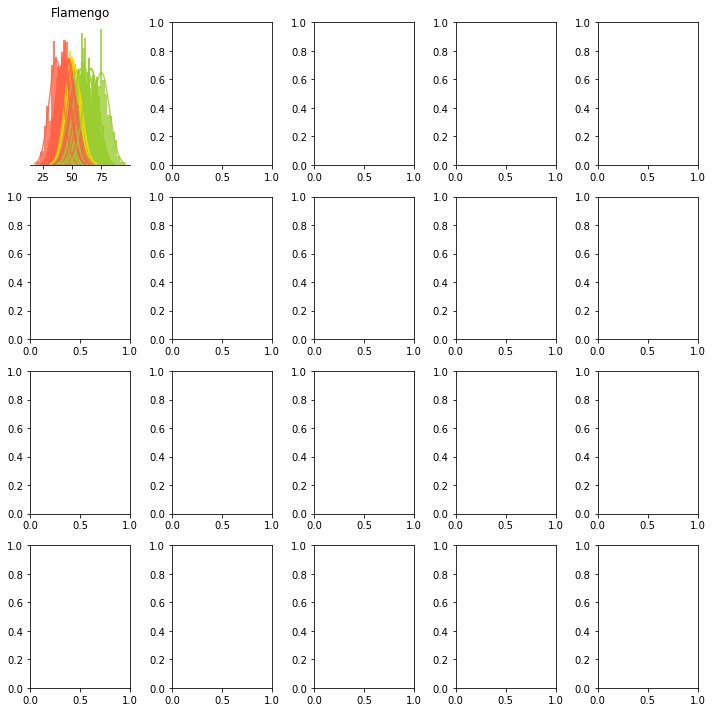

In [80]:
fig, axs = plt.subplots(4,5, figsize=(10,10), tight_layout=True)

j = 0

risco_rebai = [] #Lista pra salvar informações de quem tem chances de cair

for i in df_clubes.clubeId:
    
    nome = df_clubes.loc[(df_clubes.clubeId == int(i)), 'clubeShortName'].values[0] # Nome para o titulo
    
    # Configura o gráfico
    axs[j//5][j%5].set_title(nome)
    axs[j//5][j%5].get_yaxis().set_visible(False)
    axs[j//5][j%5].spines['right'].set_visible(False)          
    axs[j//5][j%5].spines['top'].set_visible(False)
    axs[j//5][j%5].spines['left'].set_visible(False)
    
    # Faz um 'teste de hipótese' pra ver o p-valor para a hipótese 'menos que 45 pontos'
    
    pts_fin = np.array(pontuacao_final[str(i)])
    mu = pts_fin.mean()
    sigma = pts_fin.std()
    
    z_value = (44.5-mu)/sigma
    p_value = st.norm.cdf(z_value)
    
    # sequencia de IF que controla a cor do histograma e salva quem pode cair
    if p_value > 0.3:
        
        risco_rebai.append([i, df_clubes.loc[(df_clubes.clubeId == int(i)), 'clubeNomeCodigo'].values[0], mu, sigma])
            
        axs[j//5][j%5].hist(pontuacao_final[str(i)], color='#FF6347',density=True, alpha=0.8, bins=20)
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
        axs[j//5][j%5].plot(x, st.norm.pdf(x, mu, sigma), '-', color='#FF6347', alpha=0.8)
        
    
    elif p_value > 0.1:
        
        risco_rebai.append([i, df_clubes.loc[(df_clubes.clubeId == int(i)), 'clubeNomeCodigo'].values[0], mu, sigma])
        
        axs[j//5][j%5].hist(pontuacao_final[str(i)], color='#FFD700',density=True, alpha=0.8, bins=20)
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
        axs[j//5][j%5].plot(x, st.norm.pdf(x, mu, sigma), '-', color='#FFD700', alpha=0.8)
    
    else:

        axs[j//5][j%5].hist(pontuacao_final[str(i)], color='#9ACD32',density=True, alpha=0.8, bins=20)
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
        axs[j//5][j%5].plot(x, st.norm.pdf(x, mu, sigma), '-', color='#9ACD32', alpha=0.8)

In [81]:
n = 10000 # Numero de simulacoes
df_rebaixado = pd.DataFrame()

for i in risco_rebai:# Itera a lista criada acima
    
    df_rebaixado[i[1]] = np.random.normal(i[2], i[3], n) # Vetor aleatório
    df_rebaixado[i[1]] = df_rebaixado[i[1]].apply(lambda x: round(x, 3)) # Arrendonda-se para não sobrecarregar a memória ram
    
    
# Laço para contar a frequencia em que o clube aparece no Z4     
feq_rebaixamento = pd.Series()
for i in range(n):
    
    cairam = df_rebaixado.loc[i].sort_values()[:4].index # 4 rebaixados do cenário i
    
    for i in cairam: # Itera cada um deles
        if i in feq_rebaixamento:
            feq_rebaixamento[i] += 1/n
        else:
            feq_rebaixamento[i] = 1/n
            
feq_rebaixamento # Resultado

JUV    0.8727
ACG    0.6014
BOT    0.2622
CEA    0.3283
AVA    0.5025
FOR    0.2783
CFC    0.5442
GOI    0.2697
SAO    0.1379
BGT    0.1041
SAN    0.0987
dtype: float64

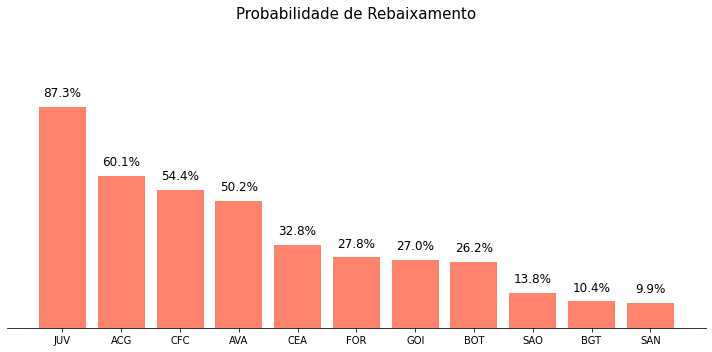

In [82]:
fig, axs = plt.subplots(1, 1, figsize=(10,5))

# Plota as informações
axs.bar(feq_rebaixamento.sort_values(ascending=False).index, 100*feq_rebaixamento.sort_values(ascending=False), alpha=0.8, color='#FF6347')

# Configura o gráfico
axs.get_yaxis().set_visible(False)
axs.spines['right'].set_visible(False)          
axs.spines['top'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_ylim(ymax=120)

eixo = axs.patches
legenda = [f'{round(100*i,1)}%' for i in feq_rebaixamento.sort_values(ascending=False)]

for eixo, legenda in zip(eixo, legenda):
    height = eixo.get_height()
    axs.text(eixo.get_x() + eixo.get_width() / 2, height + 3, legenda,
            ha='center', va='bottom', fontsize=12)

axs.set_title('Probabilidade de Rebaixamento', fontsize=15)

plt.tight_layout()
plt.savefig('prob rebaixamento.png', dpi=400)
plt.show()

In [83]:
lista_g4 = []

for i in df_clubes.clubeId:
    
    nome = df_clubes.loc[(df_clubes.clubeId == int(i)), 'clubeNomeCodigo'].values[0]
    
    pts_fin = np.array(pontuacao_final[str(i)])
    mu = pts_fin.mean()
    sigma = pts_fin.std()
    
    lista_g4.append([i, nome, mu, sigma]) # Id do clube, nome, media e desvio padrao da pontuacao final

In [84]:
n = 10000 # Numero de Simulacoes
tabela_simulada = pd.DataFrame()

for i in lista_g4:
    df_rebaixado[i[1]] = np.random.normal(i[2], i[3], n) # Vetor aleatório
    df_rebaixado[i[1]] = df_rebaixado[i[1]].apply(lambda x: round(x, 3))
    
# Laço para contar frequencia e estimar probabilidade
feq_g4 = pd.Series()
for i in range(n):
    clubes_g4 = df_rebaixado.loc[i].sort_values(ascending=False)[:4].index
    for i in clubes_g4:
        if i in feq_g4.index:
            feq_g4[i] += 1/n
        else:
            feq_g4[i] = 1/n
            
feq_g4

PAL    0.9700
FLU    0.6054
CAM    0.2380
COR    0.5313
FLA    0.7396
INT    0.2663
CEA    0.0069
BOT    0.0079
CAP    0.3855
SAN    0.0501
AME    0.0966
BGT    0.0503
GOI    0.0072
SAO    0.0262
FOR    0.0159
AVA    0.0010
ACG    0.0014
CFC    0.0004
dtype: float64

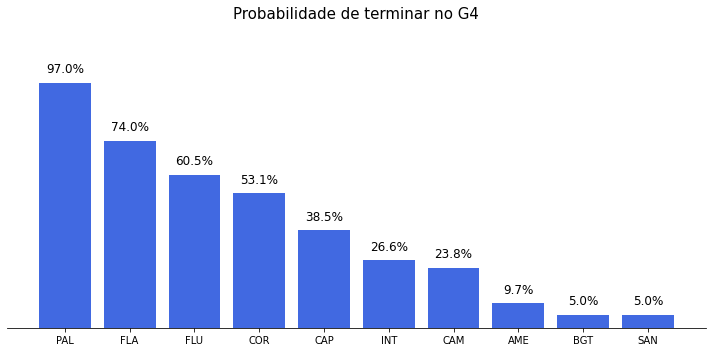

In [85]:
mask = (feq_g4 > 0.05) # Mascara para segregar quem tem mais de 5% e diminuir o ruído do gráfico


feq_g4 = feq_g4.sort_values(ascending=False) # ordena por quem tem mais probabilidade

fig, axs = plt.subplots(1, 1, figsize=(10,5))

# Plota as informações
axs.bar(feq_g4.loc[mask].index, 100*feq_g4.loc[mask], color='#4169E1')

# Configura o grafico
axs.get_yaxis().set_visible(False)
axs.spines['right'].set_visible(False)          
axs.spines['top'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_ylim(ymax=120)

eixo = axs.patches
legenda = [f'{round(100*i,1)}%' for i in feq_g4.loc[mask]]

for eixo, legenda in zip(eixo, legenda):
    height = eixo.get_height()
    axs.text(eixo.get_x() + eixo.get_width() / 2, height + 3, legenda,
            ha='center', va='bottom', fontsize=12)

axs.set_title('Probabilidade de terminar no G4', fontsize=15)

plt.tight_layout()
plt.savefig('prob de g4.png', dpi=400)
plt.show()